In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix, csc_matrix, linalg as LA
import time

# 1. Construction the matrix X

In [85]:
def construct_X(M, angles, Np=None):
    """
    Construct weight matrix for image dimensions MxM,
    angles: Array of sensor angles
    Np: number of sensors
    
    Indice names:
    i_p : sensor index
    i_o : angle/orientation index
    i = i_p + Np * i_o  : response index
    a, b : image coordinates
    j = a + M * b   : flattened image coordinates
    """
    if Np is None:
        Np = int(np.ceil(np.sqrt(2) * M))
        Np = Np if Np % 2 == 0 else Np + 1
        print(f"Np = {}")
    # index boundaries
    D = M**2
    No = len(angles)
    N = No * Np
    
    # coordinate matrix: coordinates of all pixel centers
    # as column vectors
    C = np.mgrid[M-1:-1:-1, :M:1].astype(np.float64).reshape(2, -1)
    center = M / 2
    C += 0.5 - center
        
    # convert angles from degrees to radians
    angles = np.unwrap(np.deg2rad(angles))
    
    # matrix of normal vectors for sensor positions
    n = np.column_stack([np.sin(angles), np.cos(angles)])
    
    # position of sensor 0 to sensor coordinate system
    s0 = Np / 2 - 0.5
    
    # projections of pixel onto sensor
    # first dim: angles, 2. dim: j
    p = np.dot(n, C) + s0

    # floor as left sensor index, fraction as weight for right sensor
    i_ind1, weight2 = np.divmod(p, 1)
    # weight for left sensor, indices for right sensor
    weight1 = 1 - weight2
    i_ind2 = i_ind1 + 1
    # filter all sensor out of range
    mask1 = np.logical_and(i_ind1 >= 0, i_ind1 < Np)
    mask2 = np.logical_and(i_ind2 >= 0, i_ind2 < Np)
    # transform i_ind from i_p to i = i_p + Np * i_o
    for i_o in range(No):
        i_ind1[i_o] += i_o * Np
        i_ind2[i_o] += i_o * Np
    # generate j_indices from mask
    j_ind1 = np.nonzero(mask1.flatten())[0] % D
    j_ind2 = np.nonzero(mask2.flatten())[0] % D
    # concatenate & flatten all indices and weights
    weights = np.concatenate((weight1[mask1].flatten(), weight2[mask2].flatten()))
    i_ind = np.concatenate((i_ind1[mask1].flatten(), i_ind2[mask2].flatten()))
    j_ind = np.concatenate((j_ind1, j_ind2))
    
    # construct sparse matrix convert to csc-matrix for solving
    return coo_matrix((weights, (i_ind, j_ind)), shape=(N, D), dtype=np.float32).asformat('csc')

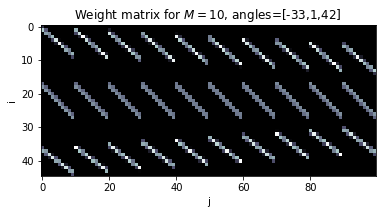

In [86]:
# Test function with example given on sheet
X = construct_X(10, [-33, 1, 42])
X_dense = X.todense()
plt.imshow(X_dense, cmap='bone')
plt.ylabel('i'); plt.xlabel('j')
plt.title('Weight matrix for $M=10$, angles=[-33,1,42]')
# check if computed matrix is equal to example
X_ex = np.load('hs_tomography/X_example.npy')
assert(np.array_equal(X_ex, X_dense))

# 2. Recovering the image

In [87]:
def image(alphas, response, M, Np, tol=1e-4, verbose=True):
    "Recover image and measure time"
    if verbose:
        print(f"Recovering image with M={M}, Np={Np}, No={len(alphas)}, tolerance={tol}")
    t0 = time.time()
    # construct weight matrix
    X = construct_X(M, alphas, Np)
    t1 = time.time()
    if verbose:
        print(f"Sparsity of X: {X.nnz / np.product(X.shape)}, Time to construct X: {t1-t0:.2f}s")
    # find least squares solution
    beta = LA.lsqr(X, response, atol=tol, btol=tol)[0]
    t2 = time.time()
    if verbose:
        print(f"Solved for image in {t2-t1:.2f}s with tolerance {tol}, total time {t2-t0:.2f}s")
    return beta.reshape(M,M)

In [88]:
# Reconstruction of the low quality image
alphas = np.load('hs_tomography/alphas_77.npy')
response = np.load('hs_tomography/y_77.npy')
beta77 = image(alphas, response, tol=1e-6, M=77, Np=109)

Recovering image with M=77, Np=109, No=90, tolerance=1e-06
Sparsity of X: 0.01834862385321101, Time to construct X: 0.10s
Solved for image in 1.94s with tolerance 1e-06, total time 2.04s


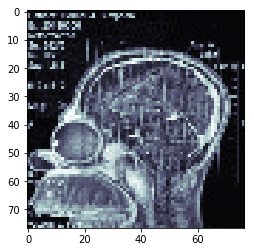

In [89]:
fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(beta77, cmap='bone');

In [91]:
# Reconstruction of the high quality image
alphas = np.load('hs_tomography/alphas_195.npy')
response = np.load('hs_tomography/y_195.npy')
beta195 = image(alphas, response, tol=1e-5, M=195, Np=275)

Recovering image with M=195, Np=275, No=179, tolerance=1e-05
Sparsity of X: 0.007272716587714439, Time to construct X: 1.44s
Solved for image in 13.26s with tolerance 1e-05, total time 14.70s


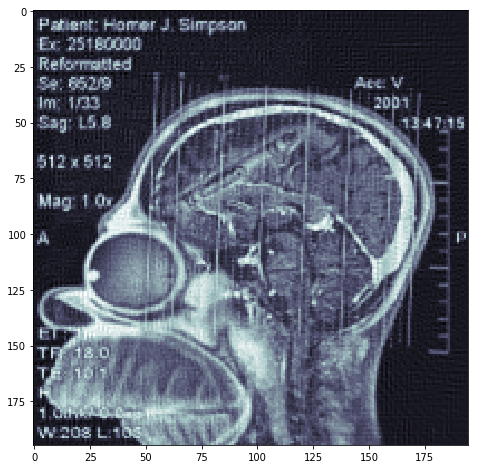

In [92]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(beta195, cmap='bone');

As we can see in the ct scan, H.S. has a long thin object in his forehead, maybe a pen or a nerf dart.

# 3. Minimizing the radiation dose

In [93]:
# calculate images with subsets of angles
images = []
for i in range(9):
    images.append(image(alphas[::i+1], response.reshape(-1, 275)[::i+1].reshape(-1), 195, 275))

Recovering image with M=195, Np=275, No=179, tolerance=0.0001
Sparsity of X: 0.007272716587714439, Time to construct X: 1.47s
Solved for image in 3.33s with tolerance 0.0001, total time 4.80s
Recovering image with M=195, Np=275, No=90, tolerance=0.0001
Sparsity of X: 0.007272718772205952, Time to construct X: 0.71s
Solved for image in 1.32s with tolerance 0.0001, total time 2.04s
Recovering image with M=195, Np=275, No=60, tolerance=0.0001
Sparsity of X: 0.0072727208973362815, Time to construct X: 0.47s
Solved for image in 0.80s with tolerance 0.0001, total time 1.27s
Recovering image with M=195, Np=275, No=45, tolerance=0.0001
Sparsity of X: 0.007272718772205952, Time to construct X: 0.31s
Solved for image in 0.60s with tolerance 0.0001, total time 0.91s
Recovering image with M=195, Np=275, No=36, tolerance=0.0001
Sparsity of X: 0.007272716647075622, Time to construct X: 0.26s
Solved for image in 0.43s with tolerance 0.0001, total time 0.69s
Recovering image with M=195, Np=275, No=30,

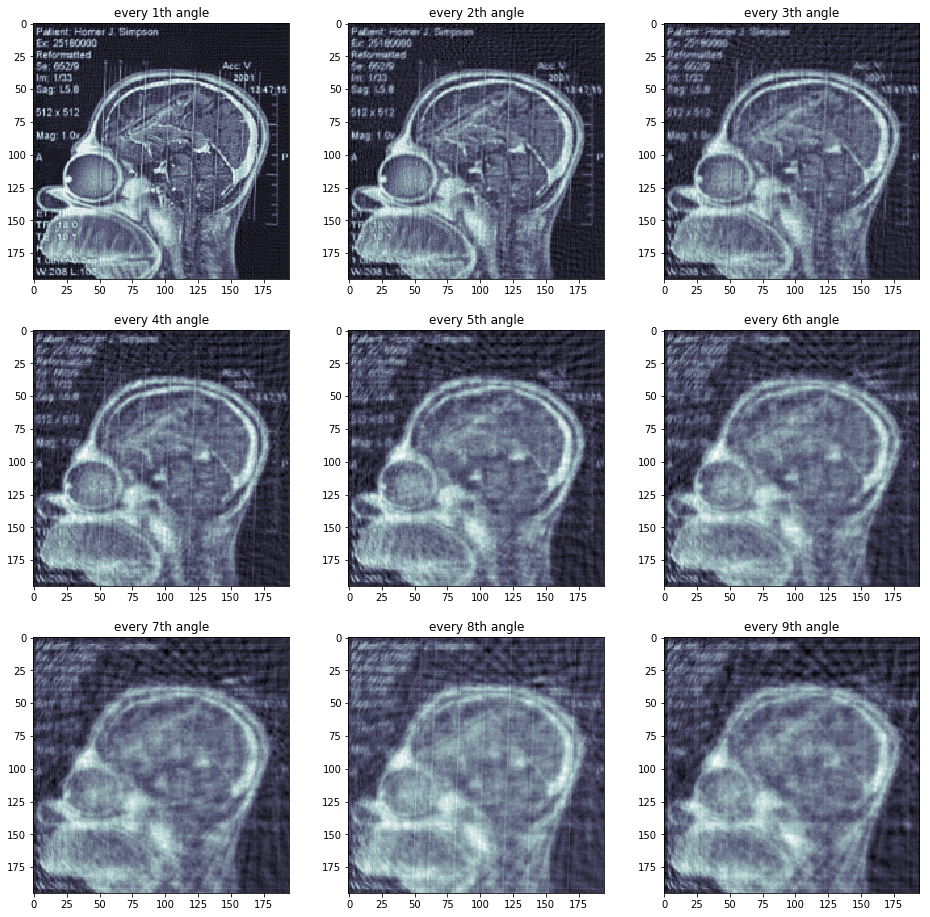

In [94]:
fig, axes = plt.subplots(3,3, figsize=(16,16))
for i, (img, ax) in enumerate(zip(images, axes.flatten())):
    ax.imshow(img, cmap='bone')
    ax.set_title(f"every {i+1}th angle")

As we can see from the images, the outline of the head can be seen even with a 9th of the angles (equally spaced between $-90^{\circ}$ and $90^{\circ}$.  
The foreign object in the head is visible with angle steps of $\leq4^{\circ}$, but only clearly with steps $\leq3^{\circ}$. So we can reduce the radiation dose by a factor of 3 and nonetheless find the object.

If we limit the angle to a $90\leq$ radius, we see much less detail in the whole image, but our foreign object is visible. This is only because of it's specific orientation, and it would not be reliable to use, but a measure at first to get an overview.

Recovering image with M=195, Np=275, No=90, tolerance=0.0001
Sparsity of X: 0.007272716647075622, Time to construct X: 0.64s
Solved for image in 2.47s with tolerance 0.0001, total time 3.11s


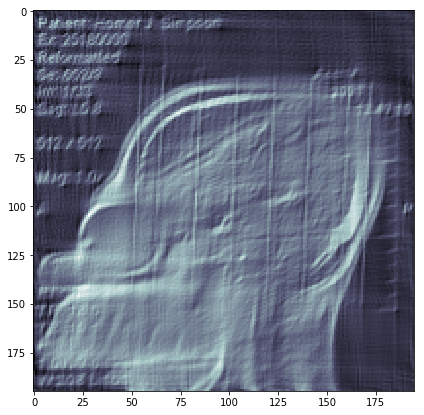

In [95]:
fig, ax = plt.subplots(figsize=(7,7))
img1 = image(alphas[:90], response.reshape(-1, 275)[:90].reshape(-1), 195, 275)
ax.imshow(img1, cmap='bone');